In [1]:
!pip install os
!pip install numpy
!pip install rasterio
!pip install glob
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


Found 242 TIFF files
Processed 0/242 bands
Processed 10/242 bands
Processed 20/242 bands
Processed 30/242 bands
Processed 40/242 bands
Processed 50/242 bands
Processed 60/242 bands
Processed 70/242 bands
Processed 80/242 bands
Processed 90/242 bands
Processed 100/242 bands
Processed 110/242 bands
Processed 120/242 bands
Processed 130/242 bands
Processed 140/242 bands
Processed 150/242 bands
Processed 160/242 bands
Processed 170/242 bands
Processed 180/242 bands
Processed 190/242 bands
Processed 200/242 bands
Processed 210/242 bands
Processed 220/242 bands
Processed 230/242 bands
Processed 240/242 bands
Hyperspectral cube created with shape: (242, 3331, 1051)


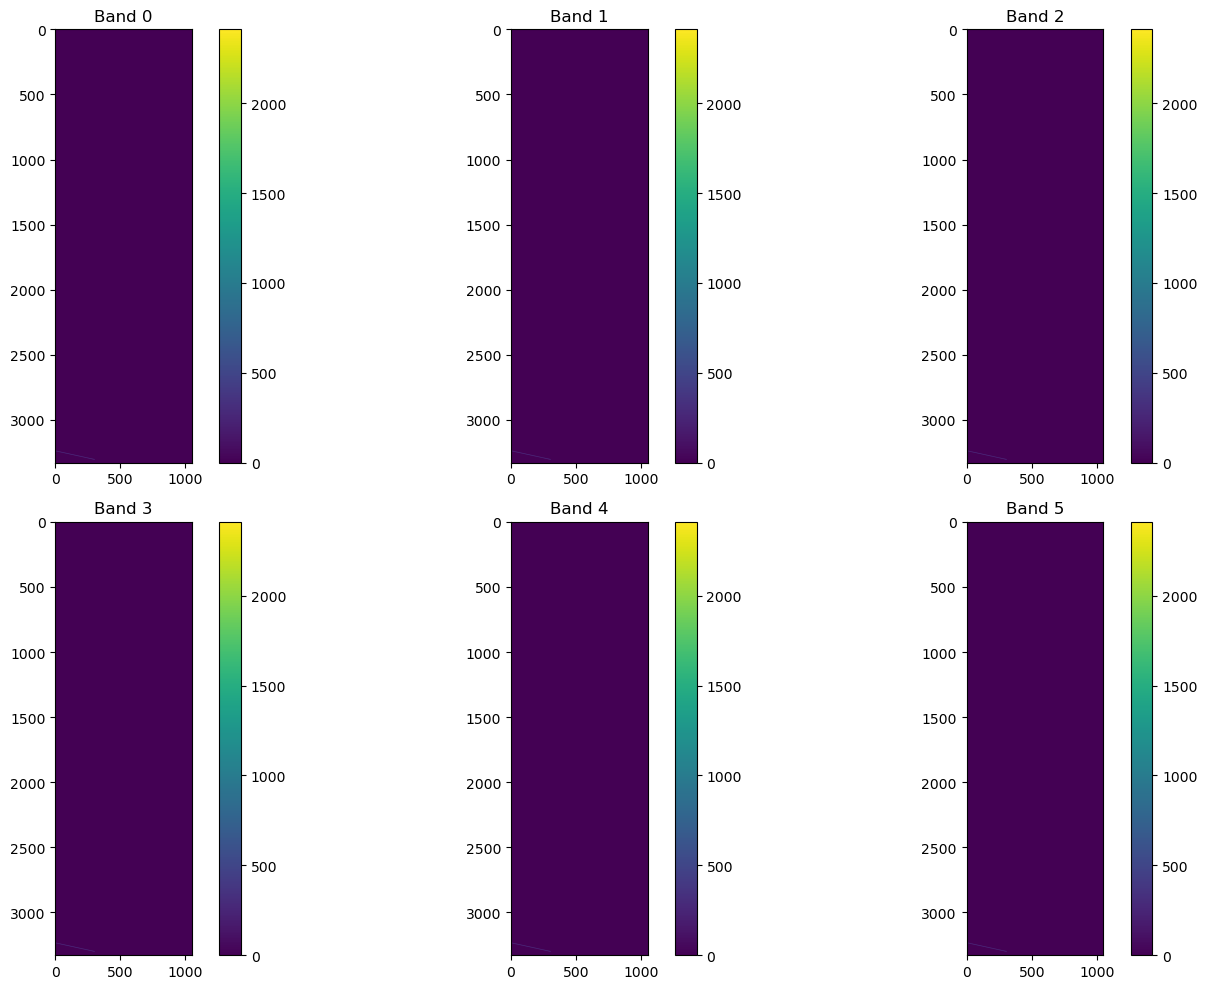

In [3]:
import os
import numpy as np
import rasterio
from glob import glob
import matplotlib.pyplot as plt

# Path to the directory containing your TIFF files
data_dir = "img1"

# Get list of all TIFF files, sort them to ensure proper band order
tiff_files = sorted(glob(os.path.join(data_dir, "*.tif")))

print(f"Found {len(tiff_files)} TIFF files")

# Read the first file to get dimensions
with rasterio.open(tiff_files[0]) as src:
    height = src.height
    width = src.width
    profile = src.profile

# Create an empty array to hold the hyperspectral cube
hypercube = np.zeros((len(tiff_files), height, width), dtype=np.float32)

# Read each file and add it as a band
for i, tiff_file in enumerate(tiff_files):
    with rasterio.open(tiff_file) as src:
        hypercube[i, :, :] = src.read(1)  # Read the first (and only) band
    
    # Print progress occasionally
    if i % 10 == 0:
        print(f"Processed {i}/{len(tiff_files)} bands")

print("Hyperspectral cube created with shape:", hypercube.shape)

# Visualize a few bands
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, len(tiff_files))):
    im = axes[i].imshow(hypercube[i, :, :], cmap='viridis')
    axes[i].set_title(f"Band {i}")
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

# Save the hyperspectral cube as a single multi-band TIFF if needed
output_profile = profile.copy()
output_profile.update(count=len(tiff_files))  # Update band count

with rasterio.open("hyperspectral_cube.tif", 'w', **output_profile) as dst:
    for i in range(len(tiff_files)):
        dst.write(hypercube[i, :, :], i+1)  # Bands are 1-indexed in rasterio

Loaded hyperspectral cube with shape: (242, 3331, 1051)
Displaying RGB composite...


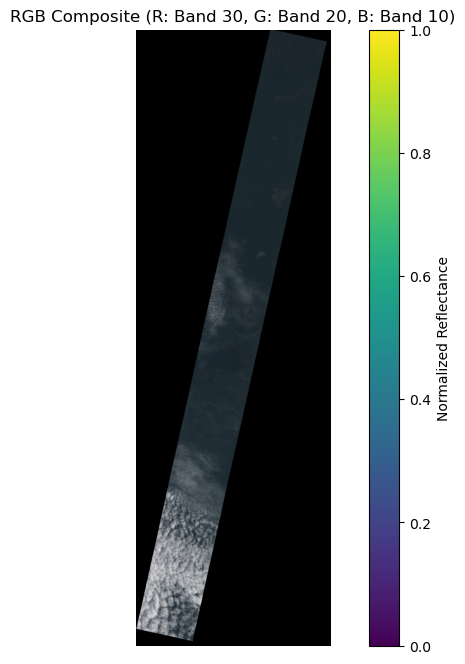

Displaying false color composite...


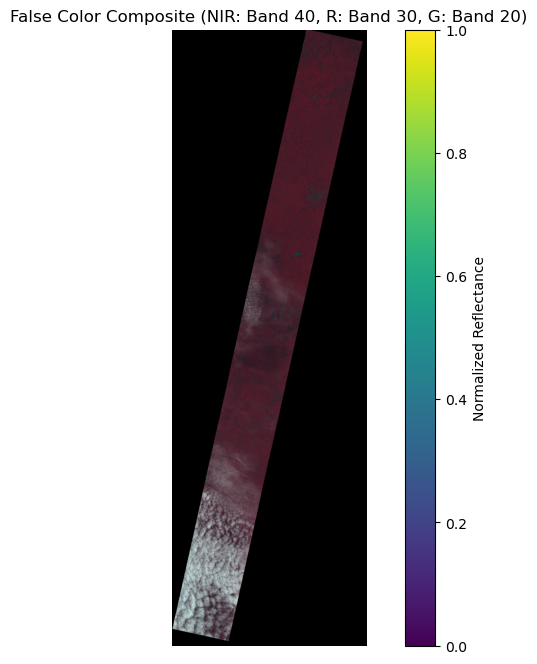

Displaying selected individual bands...


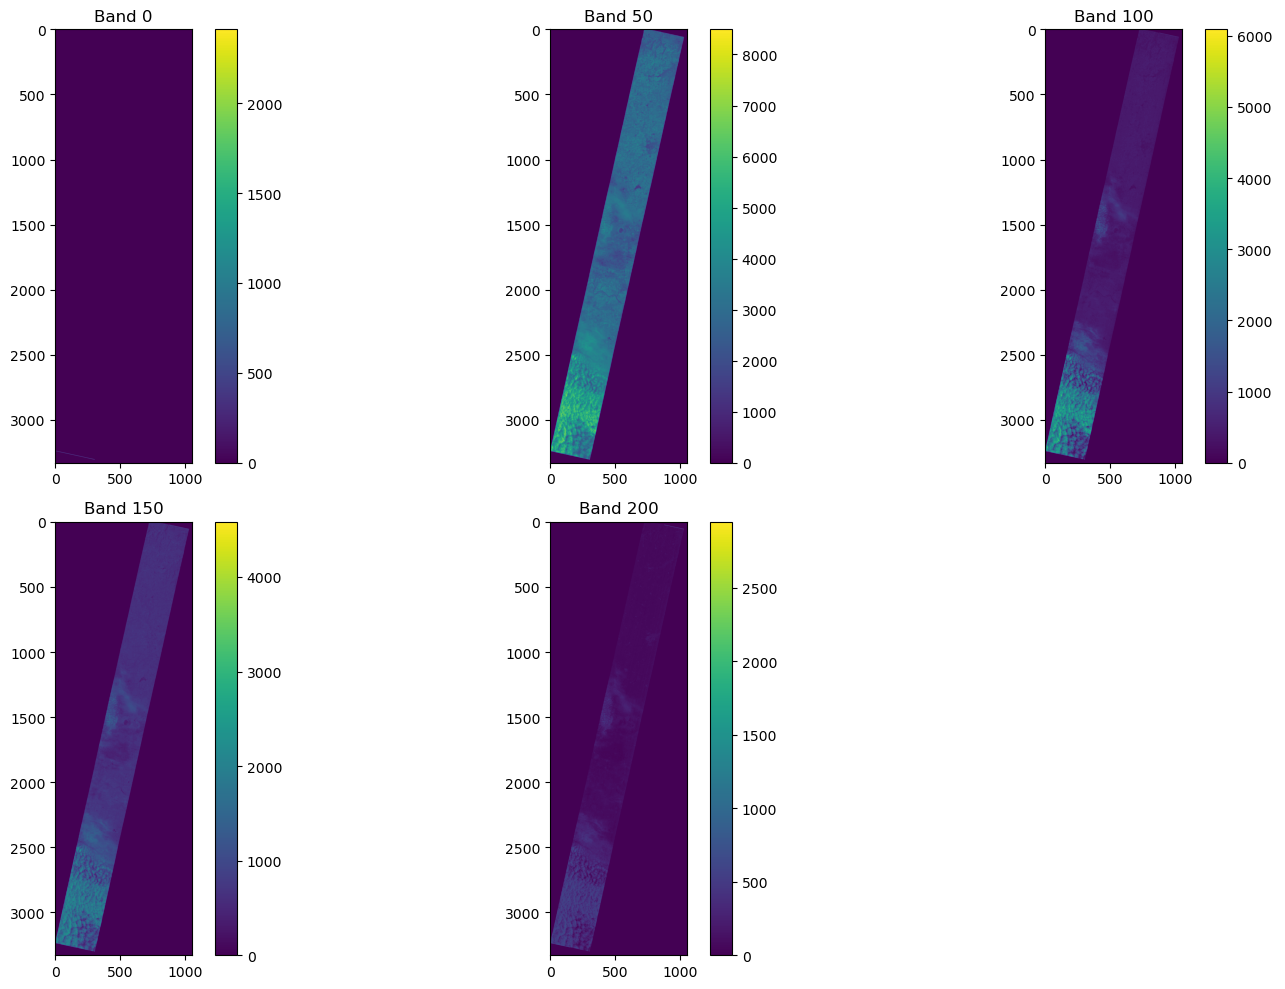

Displaying spectral profile...


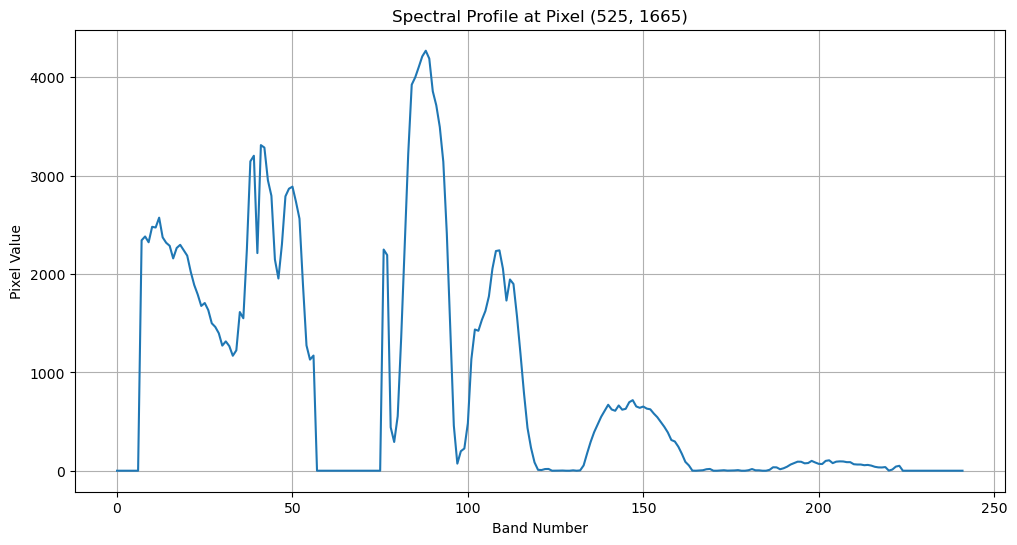

In [5]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Load the saved hyperspectral cube
with rasterio.open("hyperspectral_cube.tif") as src:
    # Get basic metadata
    num_bands = src.count
    height = src.height
    width = src.width
    
    # Read the entire cube
    hypercube = src.read()
    
    print(f"Loaded hyperspectral cube with shape: {hypercube.shape}")

# Display a true color composite (if you know which bands correspond to RGB)
# For example, if bands 30, 20, 10 roughly correspond to R, G, B:
def display_rgb_composite(hypercube, r_band=30, g_band=20, b_band=10):
    # Adjust these band indices based on your data's spectral characteristics
    # Note: band indices in the hypercube are 0-indexed
    
    # Create an RGB composite
    rgb = np.zeros((height, width, 3), dtype=np.float32)
    
    # Normalize each band to 0-1 range for visualization
    for i, band_idx in enumerate([r_band, g_band, b_band]):
        if band_idx < hypercube.shape[0]:  # Check if band exists
            band_data = hypercube[band_idx, :, :]
            # Normalize band
            band_min, band_max = np.nanmin(band_data), np.nanmax(band_data)
            if band_max > band_min:  # Avoid division by zero
                rgb[:, :, i] = (band_data - band_min) / (band_max - band_min)
    
    # Display the RGB composite
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb)
    plt.title(f"RGB Composite (R: Band {r_band}, G: Band {g_band}, B: Band {b_band})")
    plt.axis('off')
    plt.colorbar(label="Normalized Reflectance")
    plt.show()

# Display a false color composite (highlight vegetation)
def display_false_color(hypercube, nir_band=40, r_band=30, g_band=20):
    # False color using Near Infrared, Red, Green
    # Adjust these band indices based on your data
    
    # Create a false color composite
    false_color = np.zeros((height, width, 3), dtype=np.float32)
    
    # Normalize each band
    for i, band_idx in enumerate([nir_band, r_band, g_band]):
        if band_idx < hypercube.shape[0]:  # Check if band exists
            band_data = hypercube[band_idx, :, :]
            # Normalize band
            band_min, band_max = np.nanmin(band_data), np.nanmax(band_data)
            if band_max > band_min:  # Avoid division by zero
                false_color[:, :, i] = (band_data - band_min) / (band_max - band_min)
    
    # Display the false color composite
    plt.figure(figsize=(10, 8))
    plt.imshow(false_color)
    plt.title(f"False Color Composite (NIR: Band {nir_band}, R: Band {r_band}, G: Band {g_band})")
    plt.axis('off')
    plt.colorbar(label="Normalized Reflectance")
    plt.show()

# Display multiple individual bands
def display_multiple_bands(hypercube, band_indices=[0, 50, 100, 150, 200]):
    # Adjust these indices based on what bands you want to see
    valid_indices = [idx for idx in band_indices if idx < hypercube.shape[0]]
    
    # Create subplot grid
    n_bands = len(valid_indices)
    n_cols = min(3, n_bands)
    n_rows = (n_bands + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, band_idx in enumerate(valid_indices):
        band_data = hypercube[band_idx, :, :]
        im = axes[i].imshow(band_data, cmap='viridis')
        axes[i].set_title(f"Band {band_idx}")
        fig.colorbar(im, ax=axes[i])
    
    # Hide any unused subplots
    for i in range(len(valid_indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display a spectral profile for a specific pixel
def display_spectral_profile(hypercube, x=width//2, y=height//2):
    # Extract the spectrum at the given pixel
    spectrum = hypercube[:, y, x]
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(spectrum)), spectrum)
    plt.title(f"Spectral Profile at Pixel ({x}, {y})")
    plt.xlabel("Band Number")
    plt.ylabel("Pixel Value")
    plt.grid(True)
    plt.show()

# Call the visualization functions
print("Displaying RGB composite...")
display_rgb_composite(hypercube)

print("Displaying false color composite...")
display_false_color(hypercube)

print("Displaying selected individual bands...")
display_multiple_bands(hypercube)

print("Displaying spectral profile...")
display_spectral_profile(hypercube)

In [7]:
!pip install spectral
!pip install scipy
!pip install opencv-python


Loaded hyperspectral cube with shape: (242, 3331, 1051)
NaN values: 0, Infinity values: 0
Data range: 0 to 32767
Mean: 335.86989228007803, Std: 1023.3932213121809


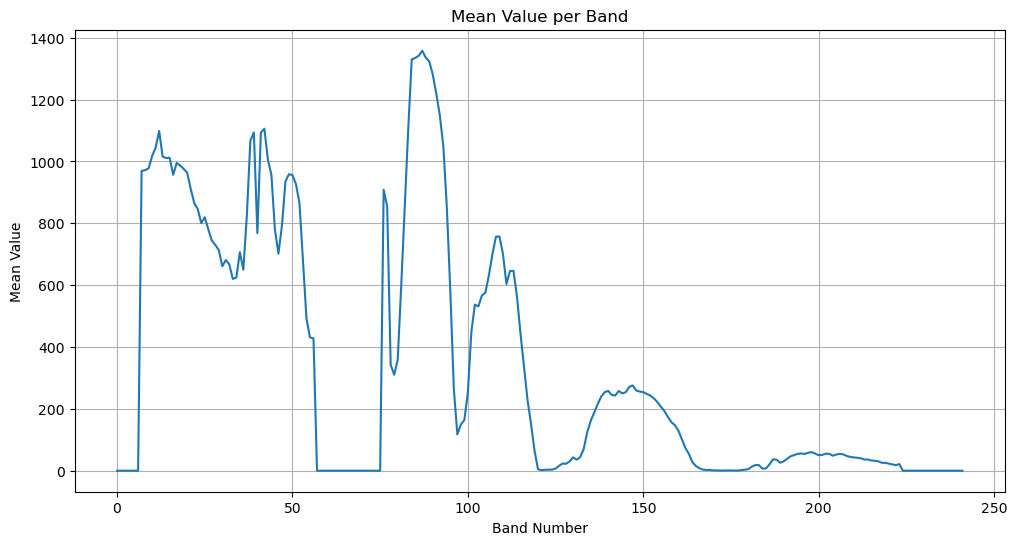

Identified 150 potentially problematic bands: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 120 121
 122 123 124 125 126 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 184 185 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241]


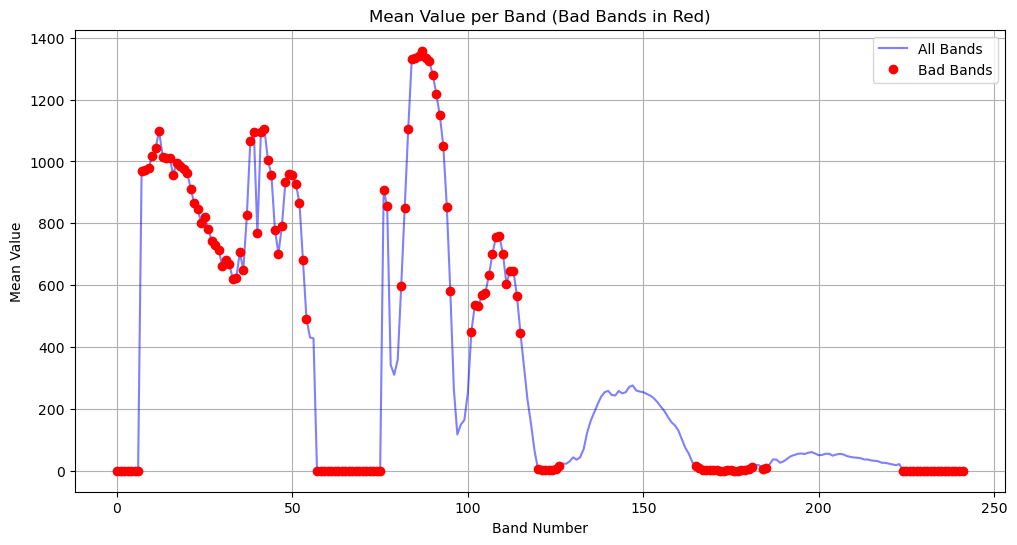

Reduced from 242 to 92 bands
step 2 completed
step 3 completed
step 4 completed


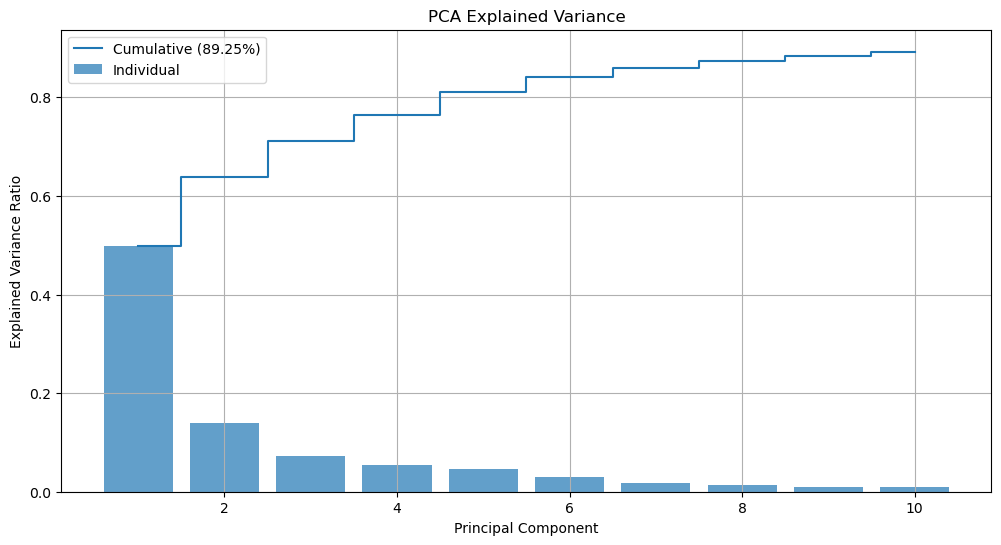

step 5 completed
Using proxy bands: Red=23, NIR=32, SWIR1=46, SWIR2=64


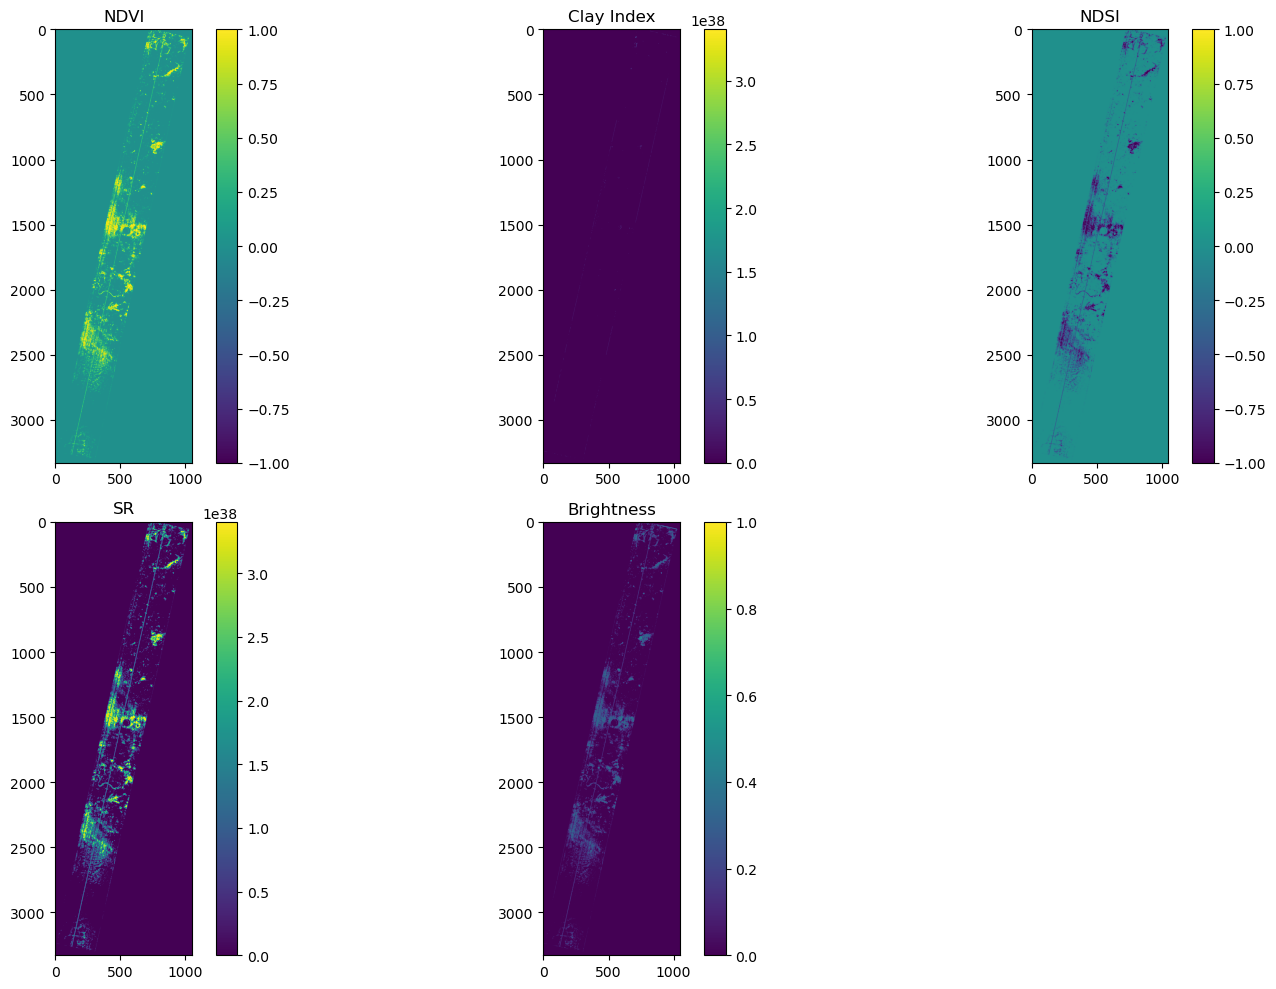

step 6 completed
Prepared data shape: (3500881, 97)
step 7 completed
Preprocessing complete. Data saved for soil property modeling.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import scipy.signal as signal
import spectral.io.envi as envi
import cv2

# Load the hyperspectral cube
with rasterio.open("hyperspectral_cube.tif") as src:
    hypercube = src.read()
    metadata = src.meta
    print(f"Loaded hyperspectral cube with shape: {hypercube.shape}")

# ----- 1. Basic Data Exploration -----
def explore_data(hypercube):
    """Display basic statistics and check for anomalies"""
    # Check for NaN or infinity values
    nan_count = np.isnan(hypercube).sum()
    inf_count = np.isinf(hypercube).sum()
    print(f"NaN values: {nan_count}, Infinity values: {inf_count}")
    
    # Overall statistics
    print(f"Data range: {np.nanmin(hypercube)} to {np.nanmax(hypercube)}")
    print(f"Mean: {np.nanmean(hypercube)}, Std: {np.nanstd(hypercube)}")
    
    # Plot band means to identify problematic bands
    band_means = np.nanmean(hypercube, axis=(1, 2))
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(band_means)), band_means)
    plt.title("Mean Value per Band")
    plt.xlabel("Band Number")
    plt.ylabel("Mean Value")
    plt.grid(True)
    plt.show()

# ----- 2. Bad Band Removal -----
def identify_bad_bands(hypercube, threshold_std=0.001, threshold_mean_ratio=5):
    """Identify bands with low information content or noise"""
    band_means = np.nanmean(hypercube, axis=(1, 2))
    band_stds = np.nanstd(hypercube, axis=(1, 2))
    
    # Bands with very low standard deviation (almost constant)
    low_std_bands = np.where(band_stds < threshold_std)[0]
    
    # Bands with abnormal mean values (could be water absorption or noise)
    mean_ratio = band_means / np.median(band_means)
    abnormal_mean_bands = np.where(
        (mean_ratio > threshold_mean_ratio) | 
        (mean_ratio < 1/threshold_mean_ratio)
    )[0]
    
    # Combined bad bands
    bad_bands = np.unique(np.concatenate([low_std_bands, abnormal_mean_bands]))
    
    print(f"Identified {len(bad_bands)} potentially problematic bands: {bad_bands}")
    
    # Plot good vs bad bands
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(band_means)), band_means, 'b-', alpha=0.5, label='All Bands')
    plt.plot(bad_bands, band_means[bad_bands], 'ro', label='Bad Bands')
    plt.title("Mean Value per Band (Bad Bands in Red)")
    plt.xlabel("Band Number")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return bad_bands

def remove_bad_bands(hypercube, bad_bands):
    """Remove identified bad bands"""
    # Create mask for good bands
    all_bands = np.arange(hypercube.shape[0])
    good_bands = np.setdiff1d(all_bands, bad_bands)
    
    # Extract only good bands
    cleaned_cube = hypercube[good_bands, :, :]
    print(f"Reduced from {hypercube.shape[0]} to {cleaned_cube.shape[0]} bands")
    
    return cleaned_cube, good_bands

# ----- 3. Noise Reduction -----
def apply_savitzky_golay(hypercube, window_length=9, polyorder=3):
    """Apply Savitzky-Golay filter to smooth spectral signatures"""
    bands, height, width = hypercube.shape
    
    # Validate parameters
    if window_length >= bands:
        window_length = bands - 1 if (bands - 1) % 2 == 1 else bands - 2
        print(f"Adjusted window_length to {window_length} based on available bands.")
    if window_length <= polyorder:
        polyorder = window_length - 1
        print(f"Adjusted polyorder to {polyorder} to fit window_length.")
    
    smoothed_cube = np.zeros_like(hypercube)
    reshaped = hypercube.reshape(bands, height * width)
    
    for i in range(height * width):
        spectrum = reshaped[:, i]
        if not np.isnan(spectrum).any():
            smoothed_cube[:, i // width, i % width] = signal.savgol_filter(
                spectrum, window_length, polyorder
            )
    
    return smoothed_cubee

# ----- 4. Continuum Removal -----
def apply_continuum_removal(hypercube):
    """Apply continuum removal to normalize spectra"""
    bands, height, width = hypercube.shape
    normalized_cube = np.zeros_like(hypercube)
    
    # Process each pixel
    for y in range(height):
        for x in range(width):
            spectrum = hypercube[:, y, x]
            # Skip pixels with NaN values
            if not np.isnan(spectrum).any():
                # Find convex hull (upper envelope)
                hull = np.zeros_like(spectrum)
                # This is a simplified version - for a more accurate continuum, 
                # consider using scipy.spatial.ConvexHull on (wavelength, reflectance) points
                hull[0] = spectrum[0]
                hull[-1] = spectrum[-1]
                for i in range(1, bands-1):
                    hull[i] = max(spectrum[i], (spectrum[0] + 
                        (spectrum[-1] - spectrum[0]) * i / (bands - 1)))
                
                # Divide by the continuum
                with np.errstate(divide='ignore', invalid='ignore'):
                    normalized_cube[:, y, x] = spectrum / hull
                    
                # Handle potential division by zero
                normalized_cube[:, y, x] = np.nan_to_num(normalized_cube[:, y, x])
    
    return normalized_cube

# ----- 5. Dimensionality Reduction -----
def apply_pca(hypercube, n_components=10):
    """Apply PCA to reduce dimensionality while preserving information"""
    bands, height, width = hypercube.shape
    
    # Reshape to 2D array (pixels x bands)
    X = hypercube.reshape(bands, height * width).T
    
    # Handle NaN values
    mask = ~np.isnan(X).any(axis=1)
    X_valid = X[mask]
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_valid)
    
    # Reshape back to image format
    pca_cube = np.zeros((n_components, height, width))
    valid_indices = np.where(mask)[0]
    
    for i, idx in enumerate(valid_indices):
        y, x = idx // width, idx % width
        pca_cube[:, y, x] = X_pca[i]
    
    # Display explained variance
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, n_components+1), explained_var, alpha=0.7, label='Individual')
    plt.step(range(1, n_components+1), cumulative_var, where='mid', 
             label=f'Cumulative ({cumulative_var[-1]:.2%})')
    plt.title("PCA Explained Variance")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pca_cube, pca

# ----- 6. Soil-Specific Indices -----
def calculate_soil_indices(hypercube, band_wavelengths=None):
    """Calculate soil-specific spectral indices"""
    # If band_wavelengths is None, we'll have to estimate which bands to use
    
    # For demonstration, let's pick bands that might be close to the needed wavelengths
    # In a real scenario, you would use the actual wavelength information
    
    # Simplified approach: Use equally spaced bands as proxies
    num_bands = hypercube.shape[0]
    
    # These are just estimates - replace with actual band positions if you have wavelength info
    red_band = int(num_bands * 0.25)  # ~650nm (Red)
    nir_band = int(num_bands * 0.35)  # ~850nm (NIR)
    swir1_band = int(num_bands * 0.5)  # ~1650nm (SWIR1)
    swir2_band = int(num_bands * 0.7)  # ~2200nm (SWIR2)
    
    print(f"Using proxy bands: Red={red_band}, NIR={nir_band}, SWIR1={swir1_band}, SWIR2={swir2_band}")
    
    # Create a multi-channel image for soil indices
    bands, height, width = hypercube.shape
    indices = np.zeros((5, height, width), dtype=np.float32)
    
    # Calculate NDVI (can indicate organic matter)
    red = hypercube[red_band]
    nir = hypercube[nir_band]
    with np.errstate(divide='ignore', invalid='ignore'):
        indices[0] = (nir - red) / (nir + red)
    indices[0] = np.nan_to_num(indices[0])
    
    # Clay Index
    swir1 = hypercube[swir1_band]
    swir2 = hypercube[swir2_band]
    with np.errstate(divide='ignore', invalid='ignore'):
        indices[1] = swir1 / swir2
    indices[1] = np.nan_to_num(indices[1])
    
    # Normalized Difference Soil Index (NDSI)
    with np.errstate(divide='ignore', invalid='ignore'):
        indices[2] = (swir1 - nir) / (swir1 + nir)
    indices[2] = np.nan_to_num(indices[2])
    
    # Simple Ratio (SR)
    with np.errstate(divide='ignore', invalid='ignore'):
        indices[3] = nir / red
    indices[3] = np.nan_to_num(indices[3])
    
    # Brightness Index
    indices[4] = (red + nir + swir1) / 3
    
    index_names = ["NDVI", "Clay Index", "NDSI", "SR", "Brightness"]
    
    # Visualize indices
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (name, idx) in enumerate(zip(index_names, indices)):
        if i < len(axes):
            im = axes[i].imshow(idx, cmap='viridis')
            axes[i].set_title(name)
            fig.colorbar(im, ax=axes[i])
    
    # Hide unused subplot
    if len(index_names) < len(axes):
        axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return indices, index_names

# ----- 7. Final Preparation for Soil Property Analysis -----
def prepare_for_soil_analysis(hypercube, indices):
    """Combine spectral data and indices for final soil analysis preparation"""
    bands, height, width = hypercube.shape
    indices_count = indices.shape[0]
    
    # Reshape hypercube for pixel-wise analysis
    pixel_data = hypercube.reshape(bands, height * width).T
    
    # Reshape indices
    indices_data = indices.reshape(indices_count, height * width).T
    
    # Combine spectral data with indices
    combined_data = np.hstack([pixel_data, indices_data])
    
    # Normalize the data
    scaler = StandardScaler()
    try:
        # Handle NaN values by operating only on valid data
        mask = ~np.isnan(combined_data).any(axis=1)
        combined_data_valid = combined_data[mask]
        combined_data_scaled = np.zeros_like(combined_data)
        combined_data_scaled[mask] = scaler.fit_transform(combined_data_valid)
    except:
        print("Warning: Scaling failed, proceeding with unscaled data")
        combined_data_scaled = combined_data
    
    # Reshape back to image format for visualization
    scaled_cube = combined_data_scaled[:, :bands].reshape(height, width, bands)
    scaled_indices = combined_data_scaled[:, bands:].reshape(height, width, indices_count)
    
    print(f"Prepared data shape: {combined_data_scaled.shape}")
    
    return combined_data_scaled, scaled_cube, scaled_indices, mask

# ----- Execute preprocessing pipeline -----
# Step 1: Explore the data
explore_data(hypercube)

# Step 2: Remove bad bands
bad_bands = identify_bad_bands(hypercube)
cleaned_cube, good_bands = remove_bad_bands(hypercube, bad_bands)
print('step 2 completed')
# Step 3: Apply smoothing
#smoothed_cube = apply_savitzky_golay(cleaned_cube)
print('step 3 completed')
# Step 4: Apply continuum removal
normalized_cube = apply_continuum_removal(cleaned_cube)
print('step 4 completed')
# Step 5: Dimensionality reduction
pca_cube, pca_model = apply_pca(normalized_cube, n_components=10)
print('step 5 completed')
# Step 6: Calculate soil indices
soil_indices, index_names = calculate_soil_indices(normalized_cube)
print('step 6 completed')
# Step 7: Final preparation
prepared_data, scaled_cube, scaled_indices, valid_mask = prepare_for_soil_analysis(
    normalized_cube, soil_indices)
print('step 7 completed')
# Save preprocessed data for soil property modeling
np.save("preprocessed_hyperspectral_data.npy", prepared_data)
np.save("valid_pixel_mask.npy", valid_mask)

print("Preprocessing complete. Data saved for soil property modeling.")

Starting unsupervised soil property analysis from hyperspectral data...
Loaded preprocessed data with shape: (3500881, 97)

Loading spectral library...


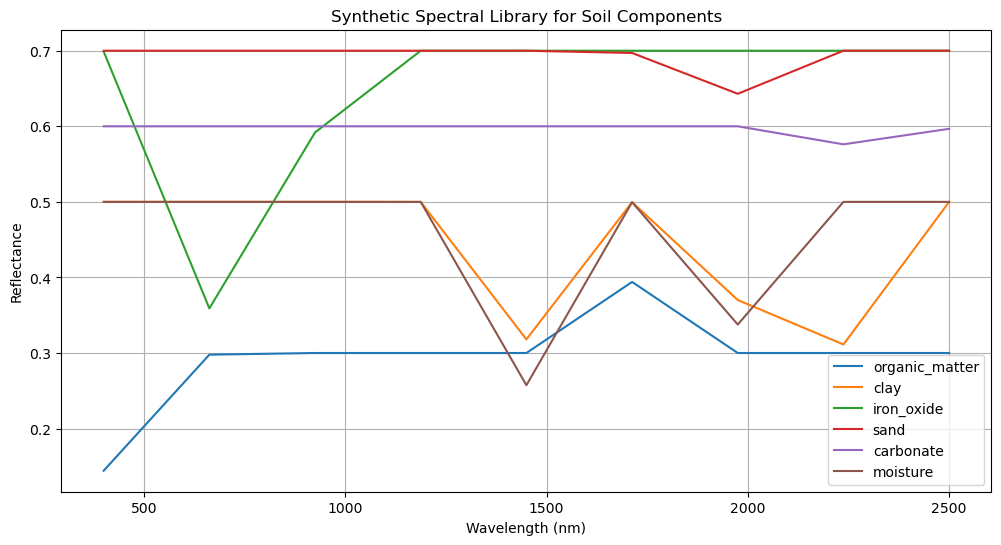

Using 9 spectral bands for analysis

Performing spectral unmixing...

Performing soil type clustering...
Performing clustering on 3500881 valid pixels

Analyzing cluster characteristics...
Cluster 0 is dominated by moisture (0.00)
Cluster 1 is dominated by clay (0.96)
Cluster 2 is dominated by iron_oxide (0.99)
Cluster 3 is dominated by sand (1.00)
Cluster 4 is dominated by organic_matter (1.00)


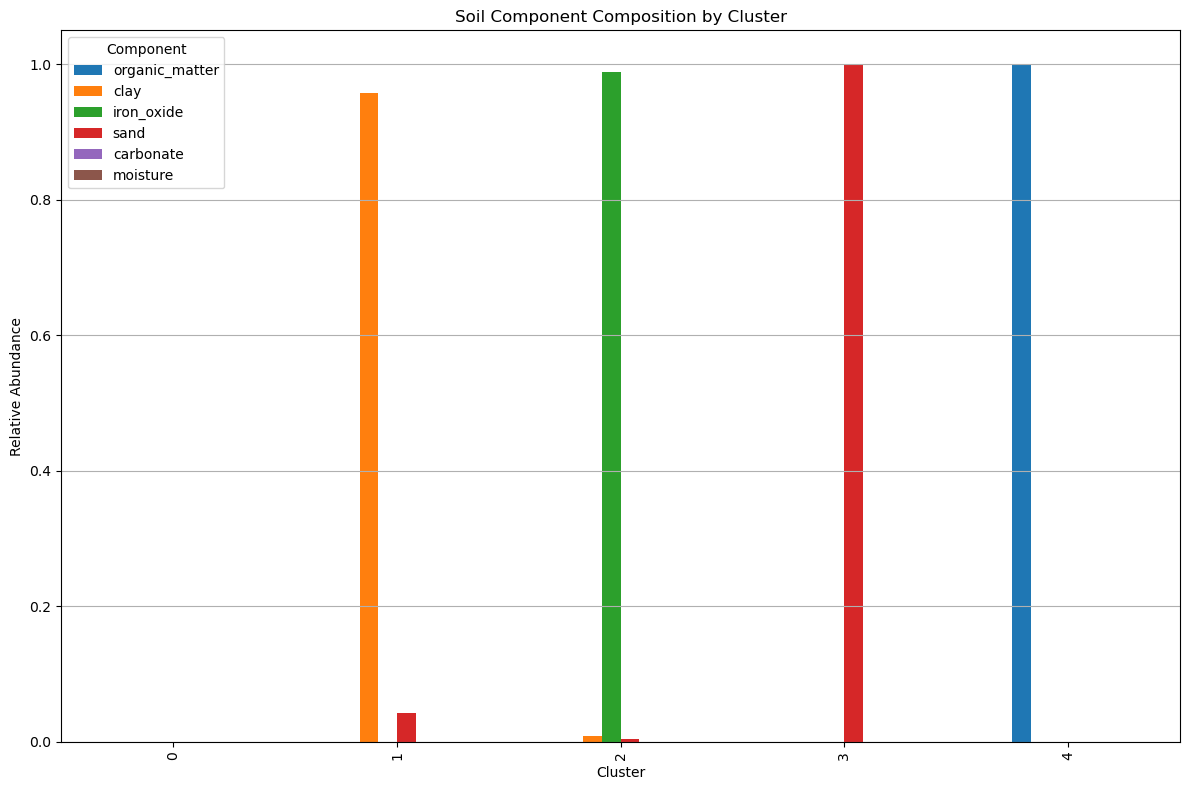


Generating soil property maps...
Found optimal dimensions: 1051x3331 for 3500881 pixels

Visualizing soil property maps...


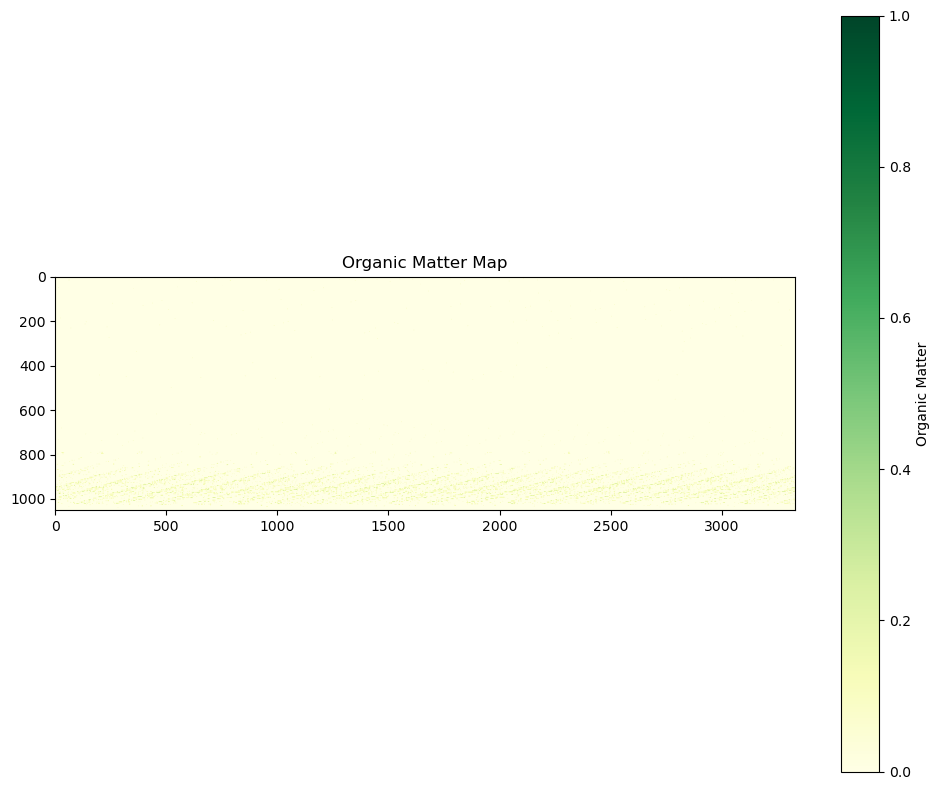

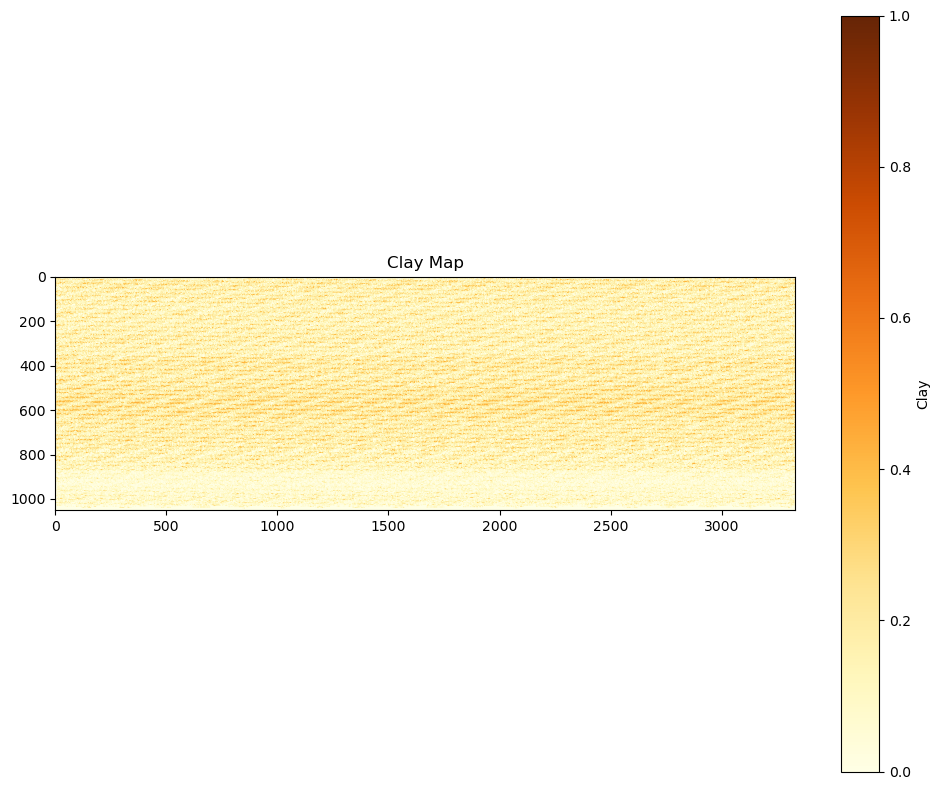

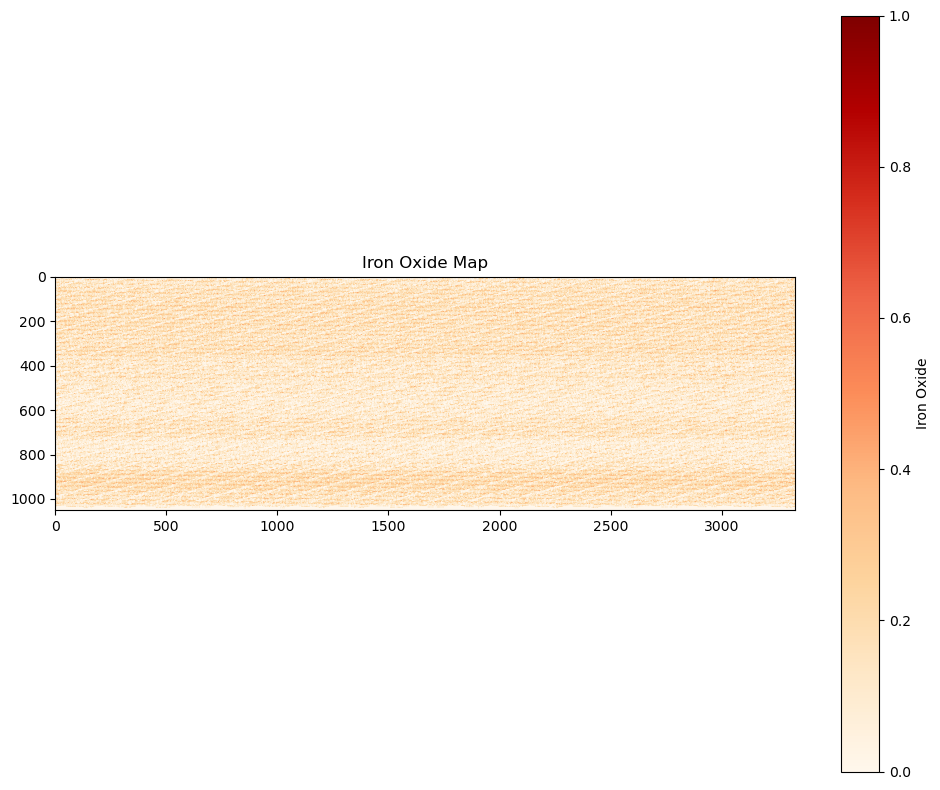

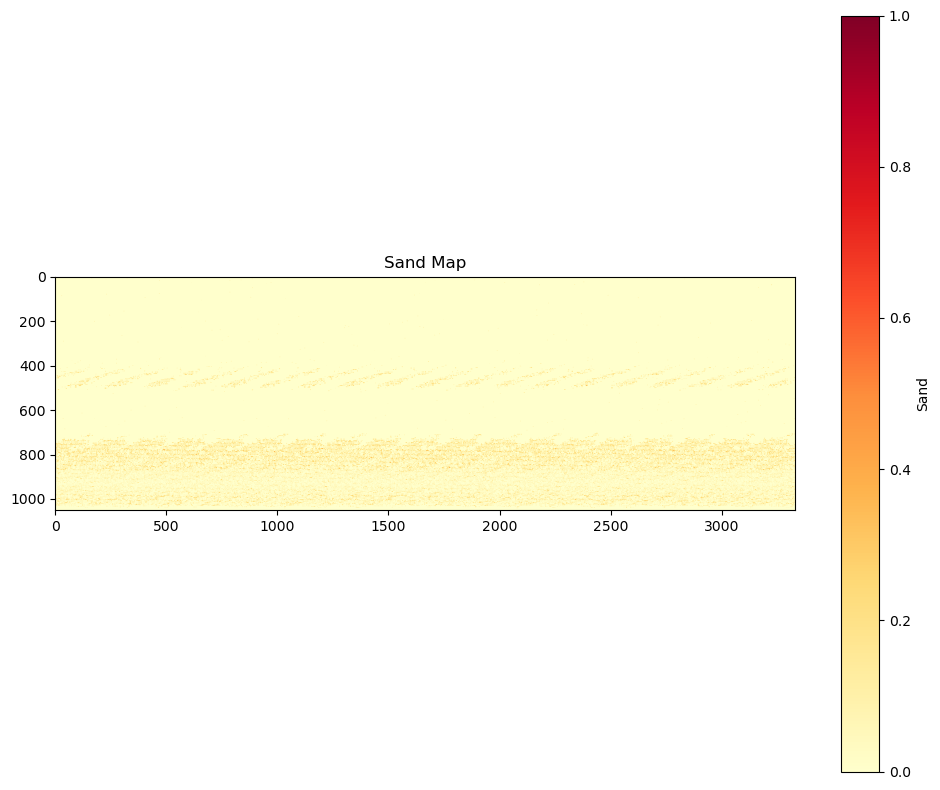

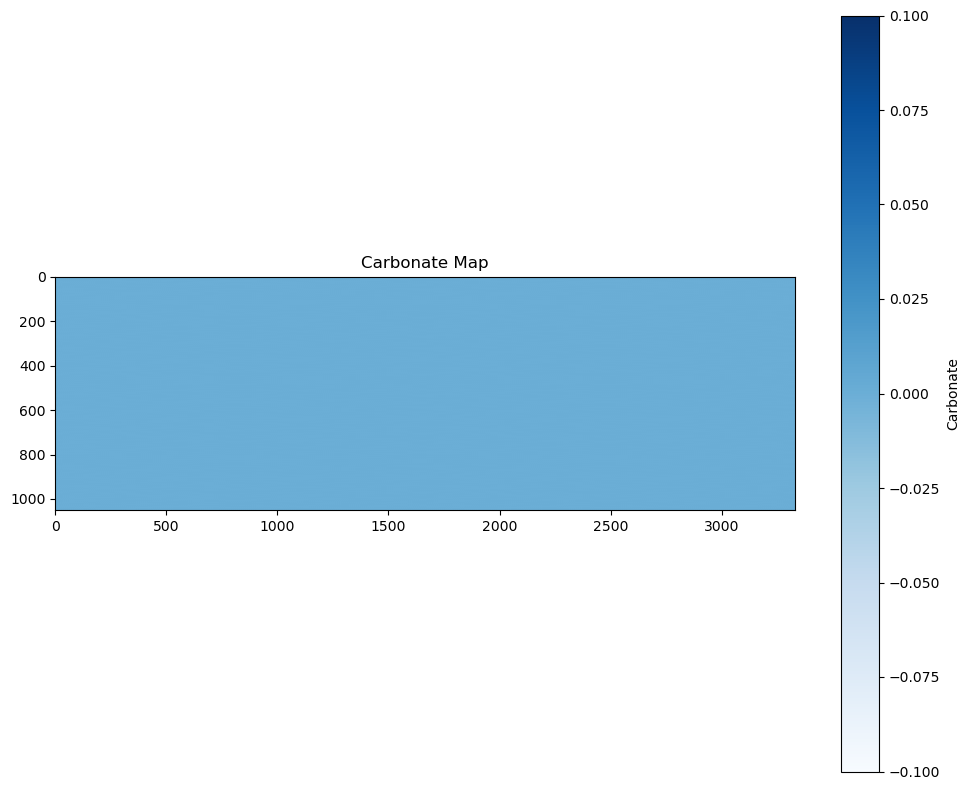

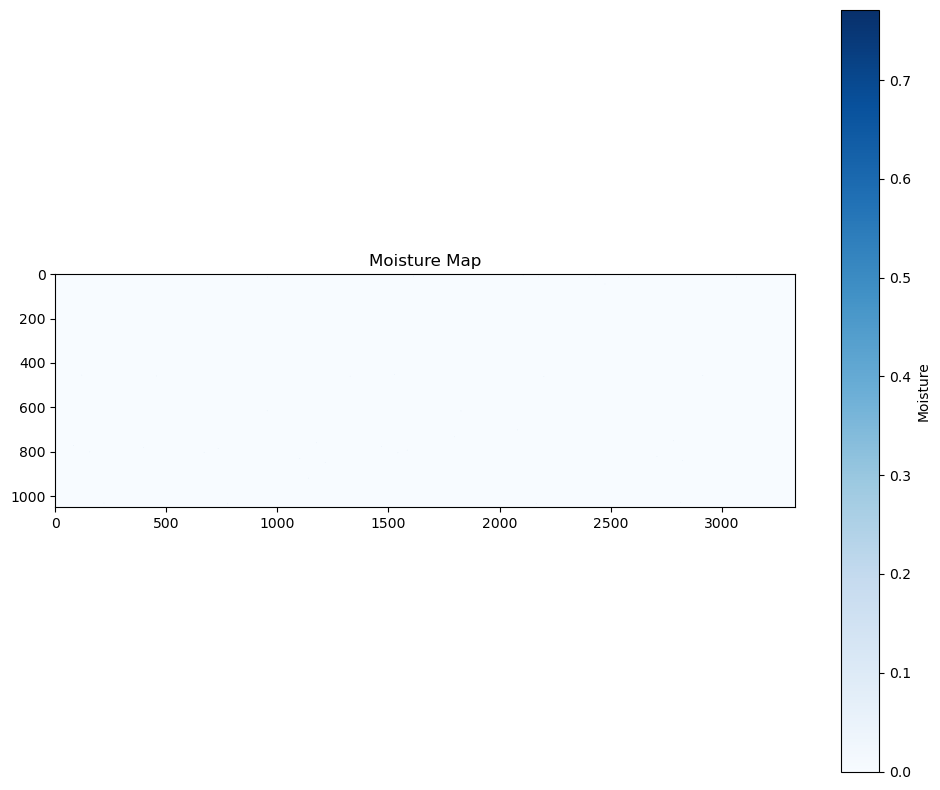

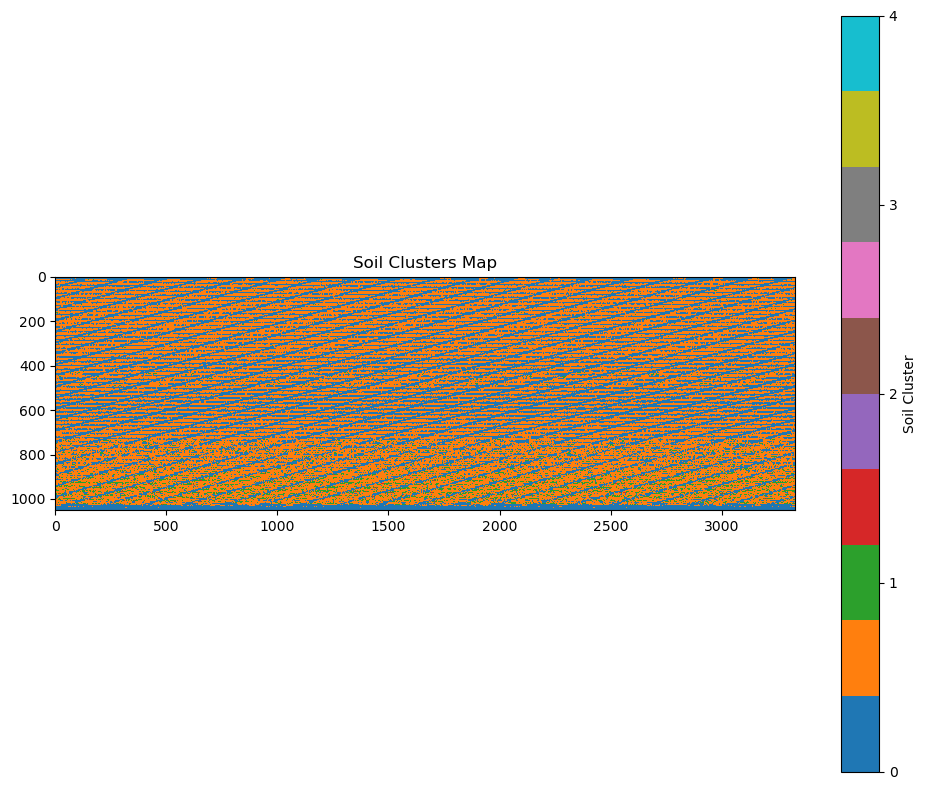

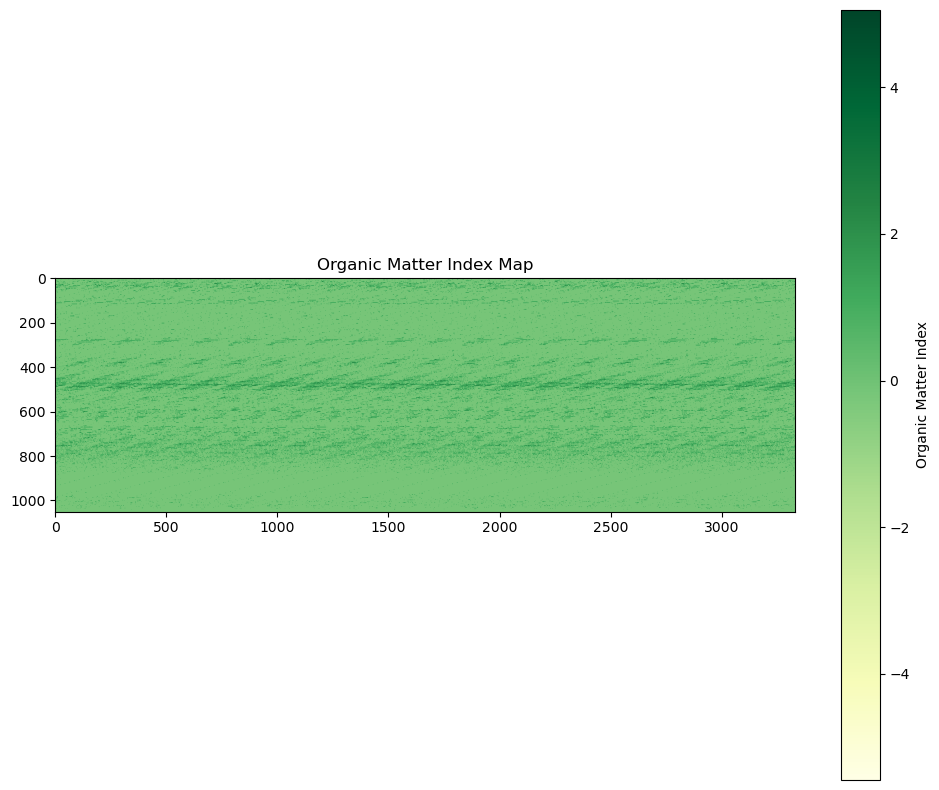

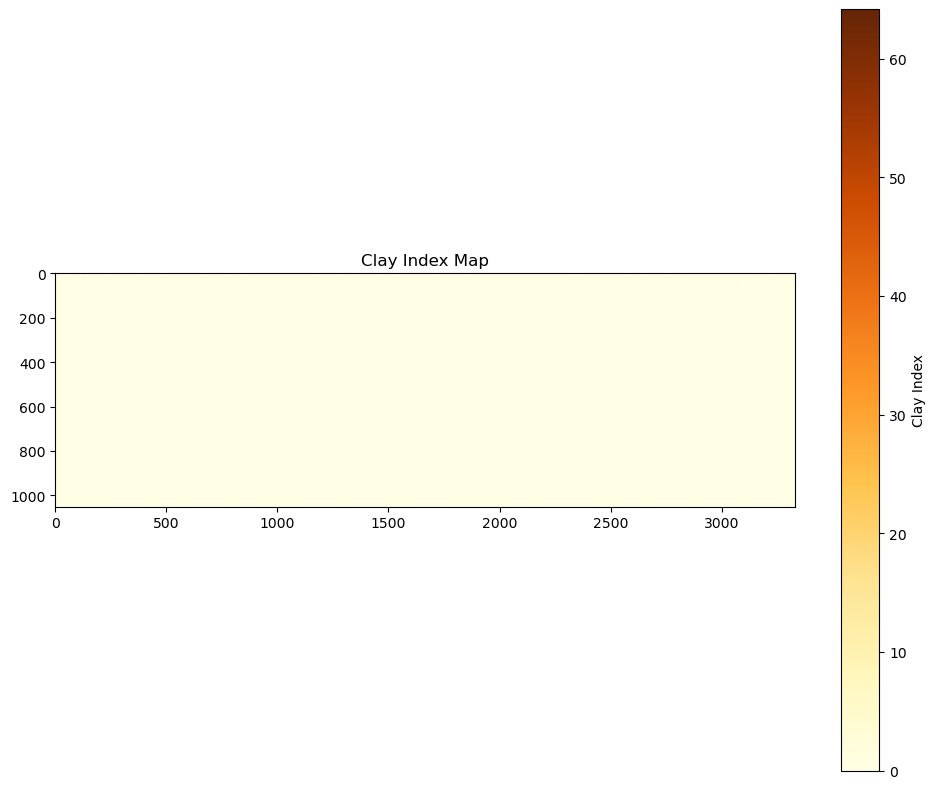

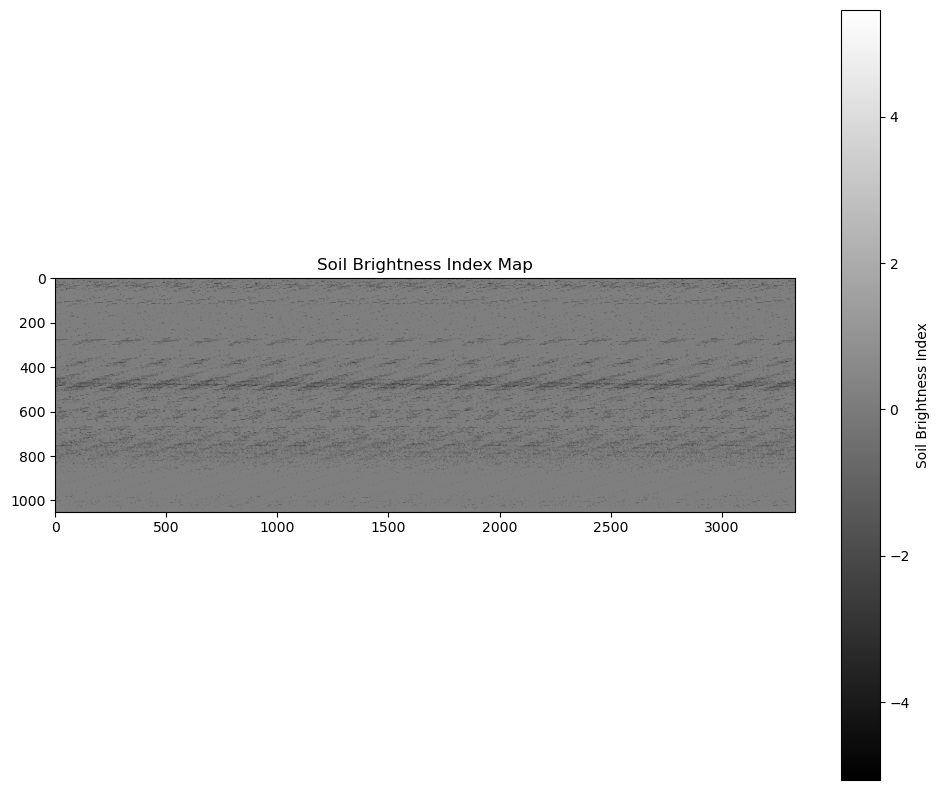

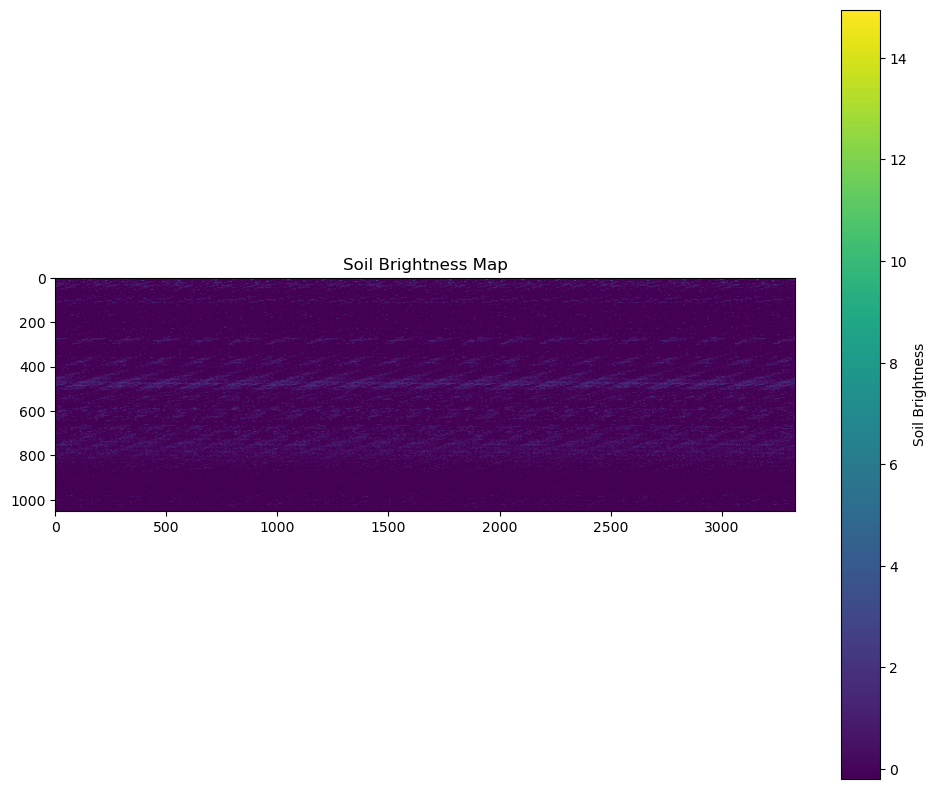


Estimating soil properties from spectral components...

Analyzing soil property distributions...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import os
import scipy.stats as stats
from scipy.spatial.distance import cdist
import joblib
import matplotlib.colors as mcolors
import math

# Load preprocessed data
def load_data():
    """Load preprocessed hyperspectral data and valid pixel mask"""
    try:
        # Load preprocessed data
        preprocessed_data = np.load("preprocessed_hyperspectral_data.npy")
        valid_mask = np.load("valid_pixel_mask.npy")
        print(f"Loaded preprocessed data with shape: {preprocessed_data.shape}")
        return preprocessed_data, valid_mask
    except FileNotFoundError:
        print("Error: Preprocessed data files not found. Run preprocessing first.")
        return None, None

# Define spectral library for common soil components
def get_spectral_library():
    """Create a basic spectral library for common soil components
    
    In a real-world scenario, you would use actual spectral libraries from
    organizations like USGS, JPL, or academic databases.
    """
    # This is a simplified synthetic spectral library
    # In reality, you would use a real spectral library with actual measurements
    
    # Number of bands - estimate from your data
    n_bands = 9  # Adjust based on your actual preprocessed data
    
    # Create synthetic spectral signatures for common soil components
    # These are NOT real spectra - just for demonstration
    wavelengths = np.linspace(400, 2500, n_bands)  # 400-2500 nm range
    
    # Organic matter (humic substances) - high absorption in visible, lower in NIR
    organic_matter = 0.3 - 0.2 * np.exp(-(wavelengths - 450)**2 / 10000) + 0.1 * np.exp(-(wavelengths - 1730)**2 / 5000)
    
    # Clay minerals - absorption features near 1400, 1900, and 2200 nm
    clay = 0.5 - 0.3 * np.exp(-(wavelengths - 1400)**2 / 5000) - 0.4 * np.exp(-(wavelengths - 1900)**2 / 5000) - 0.25 * np.exp(-(wavelengths - 2200)**2 / 5000)
    
    # Iron oxides - strong absorption in blue, high reflectance in red
    iron_oxide = 0.2 + 0.5 * (1 - np.exp(-(wavelengths - 750)**2 / 20000))
    
    # Sand (quartz) - generally high reflectance with some features
    sand = 0.7 - 0.1 * np.exp(-(wavelengths - 1900)**2 / 10000)
    
    # Carbonates - absorption features near 2350 nm
    carbonate = 0.6 - 0.3 * np.exp(-(wavelengths - 2350)**2 / 5000)
    
    # Soil moisture - water absorption bands at 1400 and 1900 nm
    moisture = 0.5 - 0.4 * np.exp(-(wavelengths - 1400)**2 / 5000) - 0.5 * np.exp(-(wavelengths - 1900)**2 / 5000)
    
    # Combine into library
    library = {
        'organic_matter': organic_matter,
        'clay': clay,
        'iron_oxide': iron_oxide,
        'sand': sand,
        'carbonate': carbonate,
        'moisture': moisture
    }
    
    # Visualize spectral library
    plt.figure(figsize=(12, 6))
    for component, spectrum in library.items():
        plt.plot(wavelengths, spectrum, label=component)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Synthetic Spectral Library for Soil Components')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return library, wavelengths

# Spectral unmixing to estimate soil components
def spectral_unmixing(data, endmembers):
    """Perform spectral unmixing to estimate abundance of soil components
    
    This uses a simplified constrained least squares approach
    """
    # Get number of endmembers and samples
    n_endmembers = endmembers.shape[0]
    n_samples = data.shape[0]
    
    # Initialize abundance array
    abundances = np.zeros((n_samples, n_endmembers))
    
    # Process each pixel
    for i in range(n_samples):
        # Skip invalid pixels
        if np.isnan(data[i]).any():
            abundances[i] = np.nan
            continue
            
        # Constrained least squares unmixing
        # Constraint: abundances >= 0 and sum(abundances) = 1
        try:
            # Solve using non-negative least squares
            from scipy.optimize import nnls
            
            # Only use spectral bands (not indices)
            n_bands = endmembers.shape[1]
            if data.shape[1] > n_bands:
                pixel_data = data[i, :n_bands]
            else:
                pixel_data = data[i]
                
            abundance, _ = nnls(endmembers.T, pixel_data)
            
            # Normalize to sum to 1
            if np.sum(abundance) > 0:
                abundance = abundance / np.sum(abundance)
                
            abundances[i] = abundance
            
        except Exception as e:
            print(f"Error processing pixel {i}: {e}")
            abundances[i] = np.nan
    
    return abundances

# Cluster analysis for soil type mapping
def perform_clustering(data, n_clusters=5):
    """Perform clustering to identify distinct soil types"""
    # Handle NaN values
    valid_data = ~np.isnan(data).any(axis=1)
    data_valid = data[valid_data]
    
    # Apply clustering
    print(f"Performing clustering on {len(data_valid)} valid pixels")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_valid)
    
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    # Create full cluster map
    cluster_map = np.full(len(data), -1)
    cluster_map[valid_data] = clusters
    
    return cluster_map, cluster_centers, kmeans

# Analyze cluster characteristics
def analyze_clusters(cluster_centers, component_names):
    """Analyze and interpret cluster characteristics"""
    # Create dataframe for cluster centers
    cluster_df = pd.DataFrame(cluster_centers, columns=component_names)
    
    # Determine dominant component in each cluster
    dominant_components = []
    for i, row in cluster_df.iterrows():
        dominant = row.idxmax()
        dominant_components.append(dominant)
        print(f"Cluster {i} is dominated by {dominant} ({row[dominant]:.2f})")
    
    # Visualize cluster centers
    plt.figure(figsize=(12, 8))
    cluster_df.plot(kind='bar', ax=plt.gca())
    plt.title('Soil Component Composition by Cluster')
    plt.ylabel('Relative Abundance')
    plt.xlabel('Cluster')
    plt.legend(title='Component')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    return dominant_components

# Get optimal image dimensions
def get_optimal_dimensions(n_pixels):
    """Determine optimal image dimensions for given number of pixels"""
    # Find factors of n_pixels
    sqrt_n = int(math.sqrt(n_pixels))
    
    # Try to find a pair of factors close to square
    width = sqrt_n
    height = n_pixels // width
    
    # Check if there's a remainder
    if width * height != n_pixels:
        # Find the closest factor pair
        best_diff = n_pixels
        for i in range(1, sqrt_n + 1):
            if n_pixels % i == 0:
                j = n_pixels // i
                diff = abs(i - j)
                if diff < best_diff:
                    best_diff = diff
                    width = j
                    height = i
    
    print(f"Found optimal dimensions: {height}x{width} for {n_pixels} pixels")
    return height, width

# Map soil properties based on spectral indices and cluster characteristics
def map_soil_properties(data, valid_mask, abundances, clusters, component_names):
    """Create soil property maps based on abundances and clustering"""
    n_components = abundances.shape[1]
    
    # Determine optimal dimensions for reshaping
    n_pixels = len(valid_mask)
    height, width = get_optimal_dimensions(n_pixels)
    
    # Initialize property maps
    property_maps = {}
    
    # Reshape abundance maps
    for i, component in enumerate(component_names):
        # Create full map with NaN for invalid pixels
        full_map = np.full(n_pixels, np.nan)
        full_map[valid_mask] = abundances[:, i]
        
        # Reshape to image dimensions
        property_map = full_map.reshape(height, width)
        property_maps[component] = property_map
    
    # Reshape cluster map
    cluster_map = np.full(n_pixels, -1)
    valid_indices = np.where(valid_mask)[0]
    cluster_map[valid_indices] = clusters
    cluster_map = cluster_map.reshape(height, width)
    
    property_maps['soil_clusters'] = cluster_map
    
    # Create soil property maps based on spectral indices already in the data
    # Assuming the indices are at the end of the feature vector
    if data.shape[1] > n_components:
        # Extract indices
        n_spectral_bands = data.shape[1] - 5  # Assuming 5 indices as in your preprocessing
        
        # NDVI (related to organic matter)
        ndvi_index = n_spectral_bands  # First index position
        ndvi_map = np.full(n_pixels, np.nan)
        ndvi_map[valid_mask] = data[valid_mask, ndvi_index]
        property_maps['organic_matter_index'] = ndvi_map.reshape(height, width)
        
        # Clay Index
        clay_index = n_spectral_bands + 1
        clay_map = np.full(n_pixels, np.nan)
        clay_map[valid_mask] = data[valid_mask, clay_index]
        property_maps['clay_index'] = clay_map.reshape(height, width)
        
        # NDSI (Normalized Difference Soil Index)
        ndsi_index = n_spectral_bands + 2
        ndsi_map = np.full(n_pixels, np.nan)
        ndsi_map[valid_mask] = data[valid_mask, ndsi_index]
        property_maps['soil_brightness_index'] = ndsi_map.reshape(height, width)
        
        # Brightness Index
        brightness_index = n_spectral_bands + 4
        brightness_map = np.full(n_pixels, np.nan)
        brightness_map[valid_mask] = data[valid_mask, brightness_index]
        property_maps['soil_brightness'] = brightness_map.reshape(height, width)
    
    return property_maps, height, width

# Visualize soil property maps
def visualize_soil_maps(property_maps):
    """Visualize generated soil property maps"""
    # Set up color maps
    property_cmaps = {
        'organic_matter': 'YlGn',
        'clay': 'YlOrBr',
        'iron_oxide': 'OrRd',
        'sand': 'YlOrRd',
        'carbonate': 'Blues',
        'moisture': 'Blues',
        'soil_clusters': 'tab10',
        'organic_matter_index': 'YlGn',
        'clay_index': 'YlOrBr',
        'soil_brightness_index': 'gray',
        'soil_brightness': 'viridis'
    }
    
    # Visualize each property map
    for property_name, property_map in property_maps.items():
        plt.figure(figsize=(10, 8))
        
        # Create masked array to handle NaN values
        masked_map = np.ma.masked_invalid(property_map)
        
        # Select colormap
        cmap = property_cmaps.get(property_name, 'viridis')
        
        # Special handling for cluster map
        if property_name == 'soil_clusters':
            # Create a discrete colormap
            unique_clusters = np.unique(masked_map.compressed())
            unique_clusters = unique_clusters[unique_clusters >= 0]  # Remove negative values
            n_clusters = len(unique_clusters)
            
            # Plot with discrete colormap
            im = plt.imshow(masked_map, cmap=cmap, vmin=0, vmax=max(n_clusters-1, 1))
            cbar = plt.colorbar(im, ticks=range(n_clusters))
            cbar.set_label('Soil Cluster')
        else:
            # Plot continuous property
            im = plt.imshow(masked_map, cmap=cmap)
            plt.colorbar(im, label=property_name.replace('_', ' ').title())
        
        plt.title(f"{property_name.replace('_', ' ').title()} Map")
        plt.tight_layout()
        plt.show()
    
    return

# Convert component abundances to estimated soil properties
def estimate_soil_properties(abundances, component_names):
    """Estimate soil properties based on component abundances"""
    n_samples = abundances.shape[0]
    
    # Initialize soil properties dictionary
    soil_properties = {
        'organic_matter_pct': np.zeros(n_samples),
        'clay_content_pct': np.zeros(n_samples),
        'soil_moisture_pct': np.zeros(n_samples),
        'pH': np.zeros(n_samples),
        'cec': np.zeros(n_samples)
    }
    
    # Map component indices
    component_indices = {name: i for i, name in enumerate(component_names)}
    
    # Estimate organic matter percentage (primarily from organic_matter component)
    if 'organic_matter' in component_indices:
        om_idx = component_indices['organic_matter']
        # Organic matter typically 0-10% in mineral soils
        soil_properties['organic_matter_pct'] = abundances[:, om_idx] * 10
    
    # Estimate clay content (from clay component)
    if 'clay' in component_indices:
        clay_idx = component_indices['clay']
        # Clay content can range from 0-60%
        soil_properties['clay_content_pct'] = abundances[:, clay_idx] * 60
    
    # Estimate soil moisture
    if 'moisture' in component_indices:
        moisture_idx = component_indices['moisture']
        # Soil moisture typically 5-35%
        soil_properties['soil_moisture_pct'] = 5 + abundances[:, moisture_idx] * 30
    
    # Estimate pH - more complex as it depends on multiple components
    # pH typically ranges from 4.5 to 8.5
    # More clay and carbonates increases pH, more organic matter decreases pH
    base_pH = 6.5  # Neutral starting point
    
    # Adjust pH based on components
    if 'organic_matter' in component_indices:
        om_idx = component_indices['organic_matter']
        soil_properties['pH'] = base_pH - abundances[:, om_idx] * 1.5  # OM decreases pH
    
    if 'clay' in component_indices:
        clay_idx = component_indices['clay']
        soil_properties['pH'] += abundances[:, clay_idx] * 0.5  # Clay slightly increases pH
    
    if 'carbonate' in component_indices:
        carb_idx = component_indices['carbonate']
        soil_properties['pH'] += abundances[:, carb_idx] * 2.0  # Carbonates increase pH significantly
    
    # Ensure pH is within realistic range
    soil_properties['pH'] = np.clip(soil_properties['pH'], 4.5, 8.5)
    
    # Estimate cation exchange capacity (CEC)
    # CEC is strongly related to clay content and organic matter
    # Typical range: 5-35 cmol/kg
    soil_properties['cec'] = 5.0  # Base CEC
    
    if 'clay' in component_indices:
        clay_idx = component_indices['clay']
        soil_properties['cec'] += abundances[:, clay_idx] * 20  # Clay has high CEC
    
    if 'organic_matter' in component_indices:
        om_idx = component_indices['organic_matter']
        soil_properties['cec'] += abundances[:, om_idx] * 30  # OM has very high CEC
    
    return soil_properties

# Visualize soil property distributions
def visualize_property_distributions(soil_properties):
    """Visualize the distributions of estimated soil properties"""
    properties = list(soil_properties.keys())
    n_properties = len(properties)
    
    # Create subplot layout
    fig, axes = plt.subplots(1, n_properties, figsize=(4*n_properties, 4))
    
    # Plot histogram for each property
    for i, prop in enumerate(properties):
        values = soil_properties[prop]
        valid_values = values[~np.isnan(values)]
        
        if len(valid_values) > 0:
            sns.histplot(valid_values, kde=True, ax=axes[i])
            axes[i].set_title(prop.replace('_', ' ').title())
            
            # Add statistics
            mean_val = np.mean(valid_values)
            median_val = np.median(valid_values)
            axes[i].axvline(mean_val, color='r', linestyle='-', label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
            axes[i].legend(fontsize='small')
    
    plt.tight_layout()
    plt.show()
    
    return

# Calculate uncertainty of estimates
def calculate_uncertainty(data, abundances, kmeans_model):
    """Calculate uncertainty of component abundance estimates"""
    # The cdist function expects data and cluster centers to have the same dimensionality
    # Since we're clustering on abundances but may have passed spectral data
    # we need to make sure we're using the same feature space
    
    # Check if we have dimension mismatch
    if data.shape[1] != kmeans_model.cluster_centers_.shape[1]:
        print(f"Dimension mismatch: data has {data.shape[1]} features but cluster centers have {kmeans_model.cluster_centers_.shape[1]}")
        print("Using abundance data for uncertainty calculation instead of spectral data")
        # Use abundance data since that's what was used for clustering
        data = abundances
    
    # Get valid data points
    valid_mask = ~np.isnan(data).any(axis=1)
    valid_data = data[valid_mask]
    valid_abundances = abundances[valid_mask]
    
    # Calculate distance to nearest cluster center
    try:
        cluster_distances = cdist(valid_data, kmeans_model.cluster_centers_)
        min_distances = np.min(cluster_distances, axis=1)
        
        # Normalize distances
        max_dist = np.max(min_distances)
        if max_dist > 0:
            normalized_distances = min_distances / max_dist
        else:
            normalized_distances = min_distances
            
        # Convert distance to uncertainty (higher distance = higher uncertainty)
        uncertainty = normalized_distances
    except ValueError as e:
        print(f"Error calculating distances: {e}")
        print("Using simplified uncertainty estimation based on cluster assignments...")
        # Fallback method - use cluster assignments directly
        cluster_assignments = kmeans_model.predict(valid_data)
        uncertainty = np.ones(len(valid_data)) * 0.5  # Default moderate uncertainty
    
    # Calculate spectral angle mapper (SAM) for each endmember
    n_samples = len(valid_abundances)
    n_components = valid_abundances.shape[1]
    sam_values = np.zeros((n_samples, n_components))
    
    # This is a simplified placeholder - in a real application,
    # you would compare to actual endmember spectra
    for i in range(n_samples):
        for j in range(n_components):
            if valid_abundances[i, j] > 0:
                # Higher angle = higher uncertainty
                # This is just a placeholder calculation
                sam_values[i, j] = uncertainty[i] * (1 - valid_abundances[i, j])
    
    return uncertainty, sam_values

# Visualize uncertainty map
def visualize_uncertainty(uncertainty, valid_mask, height, width):
    """Visualize uncertainty map"""
    # Create full uncertainty map
    full_uncertainty = np.full(len(valid_mask), np.nan)
    valid_indices = np.where(valid_mask)[0]
    full_uncertainty[valid_indices[~np.isnan(uncertainty)]] = uncertainty[~np.isnan(uncertainty)]
    
    # Reshape to image dimensions
    uncertainty_map = full_uncertainty.reshape(height, width)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    masked_map = np.ma.masked_invalid(uncertainty_map)
    im = plt.imshow(masked_map, cmap='viridis_r')  # Reversed colormap so lower values (more certain) are darker
    plt.colorbar(im, label='Uncertainty (higher = less certain)')
    plt.title('Estimate Uncertainty Map')
    plt.tight_layout()
    plt.show()
    
    return uncertainty_map

# Save results
def save_results(property_maps, output_dir="soil_property_results_unsupervised"):
    """Save soil property maps and related outputs"""
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save property maps
    for property_name, prop_map in property_maps.items():
        np.save(f"{output_dir}/{property_name}_map.npy", prop_map)
    
    # Create a simple metadata file
    with open(f"{output_dir}/metadata.txt", "w") as f:
        f.write("Soil Property Maps - Generated with Unsupervised Analysis\n")
        f.write("=======================================================\n\n")
        f.write("Maps included:\n")
        for property_name in property_maps.keys():
            f.write(f"- {property_name}\n")
        f.write("\nNote: These maps were generated using unsupervised methods and should be validated with field measurements.\n")
    
    print(f"Results saved to {output_dir}")

# Main function to run the unsupervised soil property analysis
def analyze_soil_properties_unsupervised():
    """Main function to analyze soil properties from hyperspectral data without ground truth"""
    # Load preprocessed data
    preprocessed_data, valid_mask = load_data()
    if preprocessed_data is None:
        return
    
    # Get spectral library
    print("\nLoading spectral library...")
    spectral_library, wavelengths = get_spectral_library()
    component_names = list(spectral_library.keys())
    
    # Convert dictionary to array
    endmembers = np.array([spectral_library[c] for c in component_names])
    
    # Extract spectral bands (without indices)
    n_components = len(component_names)
    n_features = preprocessed_data.shape[1]
    n_spectral_bands = min(n_features, endmembers.shape[1])
    
    print(f"Using {n_spectral_bands} spectral bands for analysis")
    
    # Extract valid data
    valid_data = preprocessed_data[valid_mask]
    valid_spectral_data = valid_data[:, :n_spectral_bands]
    
    # Perform spectral unmixing
    print("\nPerforming spectral unmixing...")
    abundances = spectral_unmixing(valid_spectral_data, endmembers)
    
    # Perform clustering for soil type mapping
    print("\nPerforming soil type clustering...")
    cluster_map, cluster_centers, kmeans_model = perform_clustering(abundances, n_clusters=5)
    
    # Analyze cluster characteristics
    print("\nAnalyzing cluster characteristics...")
    dominant_components = analyze_clusters(cluster_centers, component_names)
    
    # Map soil properties
    print("\nGenerating soil property maps...")
    property_maps, height, width = map_soil_properties(
        preprocessed_data, valid_mask, abundances, cluster_map, component_names
    )
    
    # Visualize soil maps
    print("\nVisualizing soil property maps...")
    visualize_soil_maps(property_maps)
    
    # Estimate soil properties from component abundances
    print("\nEstimating soil properties from spectral components...")
    soil_properties = estimate_soil_properties(abundances, component_names)
    
    # Visualize property distributions
    print("\nAnalyzing soil property distributions...")
    visualize_property_distributions(soil_properties)
    
    # Create property maps from soil_properties dictionary
    for prop_name, values in soil_properties.items():
        full_map = np.full(len(valid_mask), np.nan)
        valid_indices = np.where(valid_mask)[0]
        full_map[valid_indices] = values
        property_maps[prop_name] = full_map.reshape(height, width)
        
        # Visualize the map
        plt.figure(figsize=(10, 8))
        masked_map = np.ma.masked_invalid(property_maps[prop_name])
        
        # Choose colormap based on property
        if 'organic' in prop_name:
            cmap = 'YlGn'
        elif 'clay' in prop_name:
            cmap = 'YlOrBr'
        elif 'moisture' in prop_name:
            cmap = 'Blues'
        elif 'ph' in prop_name.lower():
            cmap = 'RdYlBu_r'
        else:
            cmap = 'viridis'
            
        im = plt.imshow(masked_map, cmap=cmap)
        plt.colorbar(im, label=prop_name.replace('_', ' ').title())
        plt.title(f"{prop_name.replace('_', ' ').title()} Map")
        plt.tight_layout()
        plt.show()
    
    # Calculate uncertainty
    print("\nCalculating estimation uncertainty...")
    # Pass abundances instead of spectral data to match dimensions with clustering model
    uncertainty, sam_values = calculate_uncertainty(abundances, abundances, kmeans_model)
    
    # Visualize uncertainty
    print("\nVisualizing uncertainty map...")
    uncertainty_map = visualize_uncertainty(uncertainty, valid_mask, height, width)
    property_maps['uncertainty'] = uncertainty_map
    
    # Save results
    print("\nSaving results...")
    save_results(property_maps)
    
    print("\nAnalysis complete!")
    
    return property_maps, soil_properties

# Execute the analysis
if __name__ == "__main__":
    print("Starting unsupervised soil property analysis from hyperspectral data...")
    analyze_soil_properties_unsupervised()